# Results From Conway Game of Life Simulations using CUDA


By: Annie Wilcox

## Directions for your instructor

Include detailed instructions for compiling and reproducing the results you have in this report.  Automate as much of the steps as possible to help speed up grading.


A good idea is to show your specific commands here in the jupyter notebook.  Use the exclamation point (!) to run bash commands inside of jupyter. For example:

In [3]:
!make

'make' is not recognized as an internal or external command,
operable program or batch file.


## Serial Experiment

I compiled the serial code on `dev-amd24-h200` and `dev-amd20-v100` using the following commands:

```
make clean
make
time echo "0 10" | ./gol
```

In ran the code 10 times on each developer node in order to obtain a benchmark on how long the serial code takes to run using different computers.
Runtimes (amd24-h200):
* 1:02:264s
* 1:02:269s
* 1:02:806s
* 1:02:267s
* 1:02:675s
* 1:02:775s
* 1:02:747s
* 1:02:684s
* 1:02:773s
* 1:02:947s

**amd24-h200 Average Runtime:** 1:02:661s

Runtimes (amd20-v100):
* 1:31:412s
* 1:31:459s
* 1:32:085s
* 1:31:834s
* 1:31:313s
* 1:31:300s
* 1:33:829s
* 1:31:457s
* 1:33:746s
* 1:34:334s

**and20-v100 Average Runtime:** 1:32:276s


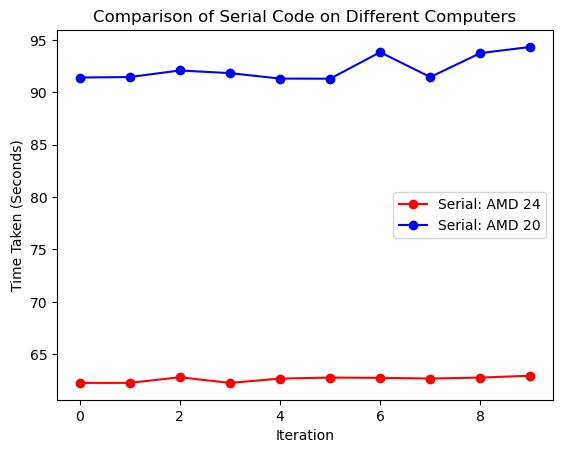

In [6]:
import pandas as pd
import matplotlib.pyplot as plt
time = {
    "Serial: AMD 24": [62.264, 62.269, 62.806, 62.267, 62.675, 62.775, 62.747, 62.684, 62.773, 62.947],
    "Serial: AMD 20": [91.412, 91.459, 92.085, 91.834, 91.313, 91.300, 93.829, 91.457, 93.746, 94.334]
}

times = pd.DataFrame(time)
plt.plot(times.index, times["Serial: AMD 24"], label = "Serial: AMD 24", marker = 'o', linestyle = '-', color = "red")
plt.plot(times.index, times["Serial: AMD 20"], label = "Serial: AMD 20", marker = 'o', linestyle = '-', color = "blue")

plt.xlabel('Iteration')
plt.ylabel('Time Taken (Seconds)')
plt.title('Comparison of Serial Code on Different Computers')


plt.legend()


plt.show()

## Compiler Optimization

After trying a variety of compiler optimizations (`O3`, `O2`, `O1`, `march=native`, `flto`, and `fnu-unroll-loops`) both separately and in conjunction, I found that I had the best luck only using the compiler flag -O2, which is a built in GCC function that provides a nice middle ground between aggressive optimizations that could mess with the integrity of the code, or basic optimizations that don't change anything about the code itself. I will note, however, that none of these optimizations resulted in a much lower average runtime. I think compiler optimizations are best used for narrowing down consistency in runtimes in this scenario less than greatly decreasing them.

(amd24-h200) Runtimes:
* 1:02:226s
* 1:02:234s
* 1:02:052s
* 1:02:087s
* 1:02:777s
* 1:02:293s
* 1:01:864s
* 1:02:690s
* 1:02:654s
* 1:02:258s

**amd24-h200 Average Runtime:** 1:02:219s, 0.71% improvement
(amd20-v100) Runtimes:
* 1:31:115s
* 1:31:504s
* 1:30:715s
* 1:31:621s
* 1:30:906s
* 1:31:305s
* 1:31:785s
* 1:31:478s
* 1:32:050s
* 1:31:476s

**amd20-v100 Average Runtime:** 1:31:396s, 0.95% improvement

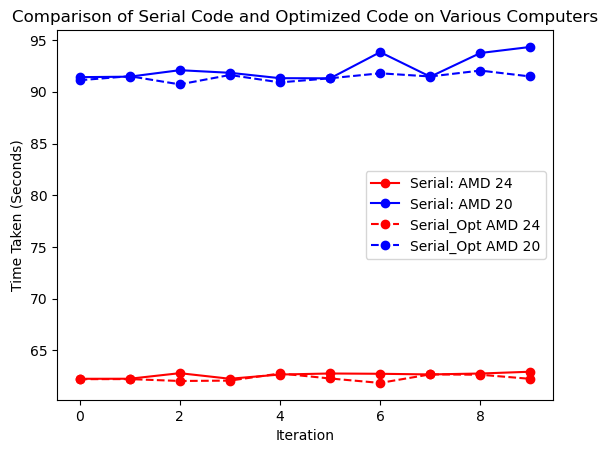

In [20]:
time = {
    "Serial: AMD 24": [62.264, 62.269, 62.806, 62.267, 62.675, 62.775, 62.747, 62.684, 62.773, 62.947],
    "Serial: AMD 20": [91.412, 91.459, 92.085, 91.834, 91.313, 91.300, 93.829, 91.457, 93.746, 94.334],
    "Serial_Opt: AMD 24": [62.226, 62.234, 62.052, 62.087, 62.777, 62.293, 61.864, 62.690, 62.654, 62.258],
    "Serial_Opt: AMD 20": [91.115, 91.504, 90.715, 91.621, 90.906, 91.305, 91.785, 91.478, 92.050, 91.476]
}

times = pd.DataFrame(time)
plt.plot(times.index, times["Serial: AMD 24"], label = "Serial: AMD 24", marker = 'o', linestyle = '-', color = "red")
plt.plot(times.index, times["Serial: AMD 20"], label = "Serial: AMD 20", marker = 'o', linestyle = '-', color = "blue")
plt.plot(times.index, times["Serial_Opt: AMD 24"], label = "Serial_Opt AMD 24", marker = "o", linestyle = "--", color = "red")
plt.plot(times.index, times["Serial_Opt: AMD 20"], label = "Serial_Opt AMD 20", marker = "o", linestyle = "--", color = "blue")

plt.xlabel('Iteration')
plt.ylabel('Time Taken (Seconds)')
plt.title('Comparison of Serial Code and Optimized Code on Various Computers')


plt.legend()


plt.show()

##### CUDA Speedup

Here is how I chose to speed up my code using CUDA:

* Allocate memory for the game state (`plate`) on the GPU
* Write a CUDA kernel function for updating/computing the game state based on the provided rules - this will run in parallel on the GPU allowing multiple iterations to take place at the same time on various threads.
* Unfortunately, `dev-amd20-v100` was returning errors when attempting to utilize CUDA (I know this was a computer error and not my own error becuase the CUDA code ran fine on `dev=amd24-h200`), so it is important to note that on this node of the supercomputer, it is likely the errors effected the runtime.

(amd24-h200) Runtimes:
* 8.225s
* 8.457s
* 8.222s
* 8.317s
* 8.245s
* 8.295s
* 8.281s
* 8.491s
* 8.380s
* 8.277s

**amd24-h200 Average Runtime:** 8.319s, 86.8% speedup

(amd20-v100) Runtimes:
* 20.371s
* 20.663s
* 31.211s
* 19.653s
* 20.038s
* 19.927s
* 20.263s
* 19.751s
* 19.815s
* 21.057s

**amd20-v100 Average Runtime:** 21.2749s, 77% speedup

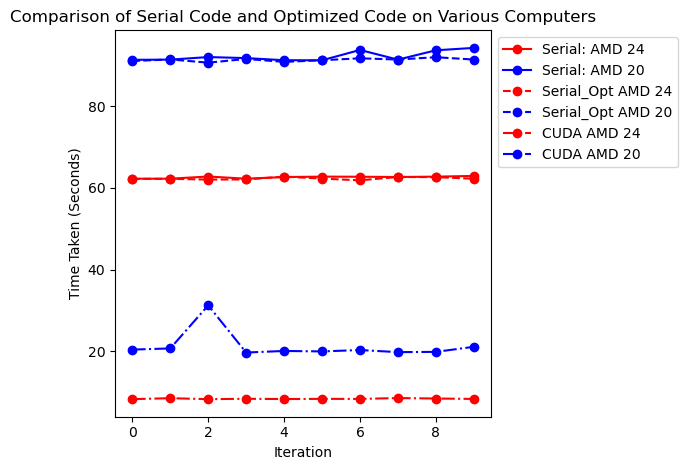

In [22]:
time = {
    "Serial: AMD 24": [62.264, 62.269, 62.806, 62.267, 62.675, 62.775, 62.747, 62.684, 62.773, 62.947],
    "Serial: AMD 20": [91.412, 91.459, 92.085, 91.834, 91.313, 91.300, 93.829, 91.457, 93.746, 94.334],
    "Serial_Opt: AMD 24": [62.226, 62.234, 62.052, 62.087, 62.777, 62.293, 61.864, 62.690, 62.654, 62.258],
    "Serial_Opt: AMD 20": [91.115, 91.504, 90.715, 91.621, 90.906, 91.305, 91.785, 91.478, 92.050, 91.476],
    "CUDA: AMD 24": [8.225, 8.457, 8.222, 8.317, 8.245, 8.295, 8.281, 8.491, 8.380, 8.277],
    "CUDA: AMD 20": [20.371, 20.663, 31.211, 19.653, 20.038, 19.927, 20.263, 19.751, 19.815, 21.057]
}

times = pd.DataFrame(time)
plt.plot(times.index, times["Serial: AMD 24"], label = "Serial: AMD 24", marker = 'o', linestyle = '-', color = "red")
plt.plot(times.index, times["Serial: AMD 20"], label = "Serial: AMD 20", marker = 'o', linestyle = '-', color = "blue")
plt.plot(times.index, times["Serial_Opt: AMD 24"], label = "Serial_Opt AMD 24", marker = "o", linestyle = "--", color = "red")
plt.plot(times.index, times["Serial_Opt: AMD 20"], label = "Serial_Opt AMD 20", marker = "o", linestyle = "--", color = "blue")
plt.plot(times.index, times["CUDA: AMD 24"], label = "CUDA AMD 24", marker = "o", linestyle = "-.", color = "red")
plt.plot(times.index, times["CUDA: AMD 20"], label = "CUDA AMD 20", marker = "o", linestyle = "-.", color = "blue")

plt.xlabel('Iteration')
plt.ylabel('Time Taken (Seconds)')
plt.title('Comparison of Serial Code and Optimized Code on Various Computers')


plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
plt.tight_layout()


plt.show()

## Concluding Discussion

The serial code ran rather slow on both computers, however, I found it interesting that `dev-amd24-h200` easily outperformed `dev-amd20-100` in every situation. This implied to me that it ends up being very important which computer you use to run your parallel code! Newer computers tend to have the most updated features which benefits the code author trying to optimize. I noticed that compiler optimizations tend to only improve execution time consistency in situations where parallel processing would be the best choice to decrease run times. When appropriately applied, it seems that CUDA is able to increase runtime speeds by up to 90% (rounded). As always, the biggest outliers I noticed were sort of explainable by the fact that developer nodes are a shared resource on the HPCC. I imagine that my outlier runtimes are explainable by someone requesting/running a job at the same time as me.

----